In [ ]:
# Full documentation available at:
# https://apidocs.redivis.com/client-libraries/redivis-python

import redivis

# We don't actually need to open the table, just needed it to open a notebook.

#table = redivis.table("tab1:ba9n")  # Reference any table in this project
#df = table.to_dataframe()      # Load table as a dataframe

# pip install boxsdk

In [ ]:
import requests
import json
#import prettytable
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import census

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Get data of county-series_code mappings
### From BLS website

In [ ]:
from urllib.request import urlopen

link = "https://download.bls.gov/pub/time.series/la/la.area"

series_names_df = pd.read_csv(link, sep='\t')



### Geography: Counties (Area type = 'F')

In [ ]:
series_names_df = series_names_df[(series_names_df.area_type_code=="F")]
series_names_df.head()

### Measure: Unemployment rate (Measure code = '03')

Make a list of series codes, by prefixing 'LAU' and suffixing '03'

In [ ]:
# Store area codes in a list
area_codes = list(series_names_df['area_code'])

# make series_codes
series_codes = [f'LAU{x}03' for x in area_codes]

len(series_codes)

series_codes[445:448]

## BLS API Limits


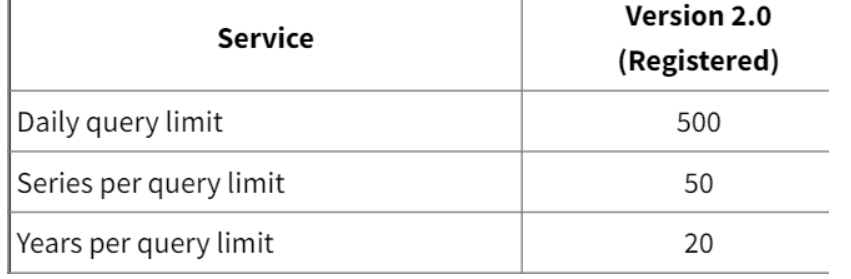

### Break list of Series_IDs into chunks

Each query can contain a maximum of

50 series, 20 years

So let each query contain 48 series.

There are N = 3224 series.

Let Years = 19. That means the time range is 2003-2022.

Each query will run to get data of 19 years for each of the 48 Series/Counties.

So, we have **68 chunks** of **48 Series** each.
The query will run 68 times. (chunk_0, chunk_1 .... chunk_67)

In [ ]:
#Define lambda function
g = globals()

final_list= lambda series_codes, x: [series_codes[i:i+x] for i in range(0, len(series_codes), x)]

#Make a list of lists (each containing 48 elements)
list_of_lists=final_list(series_codes, 48)

#Break list into chunks, naming each as chunk_{number}
for i in list_of_lists:
    g['chunk_'+str(list_of_lists.index(i))] = i

In [ ]:
chunk_1[3:6]

chunk_2[23:26]

In [ ]:
len(series_codes)

len(list_of_lists)

len(chunk_1)

#Last 68th chunk has only 8 Series_IDs
len(chunk_67)

### Loop - Call API - Append DataFrame

#### REPLACE WITH BLS API KEY

In [ ]:
#Enter BLS API Key
bls_api_key = 'user_bls_api_key'

In [ ]:
#For each chunk number from 0 (chunk_1) to 68 (chunk_67),
    #The series ID parameter is the name (chunk_1), and the 48 series inside will be passed to the API
    
    # After parsing the JSON response into a list, it is converted into a dataframe named un_df_1, named after the chunk number.

#Initialize empty dataframe

final_df = pd.DataFrame(columns=["series_id","year","period","value","footnotes"])

for y in range(68):
        params = {
          'seriesid': g[f'chunk_{y}'],
          'startyear': 2003,
          'endyear': 2022,
          'count': 1000000,
          'registrationkey': 'user_bls_api_key'
        }
        
        #Initialize empty list to store the results of each query
        un_ser_list=[]


        p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', json=params)

        json_data = json.loads(p.text)

        for series in json_data['Results']['series']:
            seriesId = series['seriesID']
            for item in series['data']:
                year = item['year']
                period = item['period']
                value = item['value']
                footnotes=""
                for footnote in item['footnotes']:
                    if footnote:
                        footnotes = footnotes + footnote['text'] + ','
                if 'M01' <= period <= 'M12':
                    un_ser_list.append([seriesId, year, period, value, footnotes[0:-1]])
        
        #Create each list into a DataFrame object stored as a global.
        g[f'un_df_{y}'] = pd.DataFrame.from_records(un_ser_list, columns=["series_id","year","period","value","footnotes"])
        
        #Append each the dataframes to final_df
        final_df=final_df.append(g[f'un_df_{y}'])
        
# The ; hides the output of this cell

### Merge county names

In [ ]:
series_names_df['county_name']=series_names_df['area_text']
series_names_df['lau']='LAU'
series_names_df['measure_code']='03'

series_names_df['series_id'] = series_names_df['lau']+series_names_df['area_code']+series_names_df['measure_code']

county_names=series_names_df[['series_id', 'county_name']]

county_names.head()
final_df.head()



In [ ]:
# merge

laus_county_03= final_df.merge(county_names, how='left', on='series_id')

laus_county_03.head()

In [ ]:
laus_county_03["county"]= laus_county_03["county_name"].str.split(",", n = 1, expand = True)[0]
laus_county_03["state_FIPS"]= laus_county_03["county_name"].str.split(",", n = 1, expand = True)[1]

laus_county_03.head()

## Add State/County IDs from Census API

#### Replace with own Census API Key

In [ ]:
census_api_key = 'user_census_api_key'

from census import Census

census_api = Census('user_census_api_key')

census_county_df = census_api.acs5.state_county(fields = ('NAME'),
                                      state_fips = "*",
                                      county_fips = "*",
                                      blockgroup = "*",
                                      year = 2020)


In [ ]:
# Make into a pandas dataframe
census_county_df = pd.DataFrame(census_county_df)

census_county_df["county_name"]= census_county_df["NAME"].str.split(",", n = 1, expand = True)[0]
census_county_df["state_name"]= census_county_df["NAME"].str.split(",", n = 1, expand = True)[1]

#Strip whitespace
census_county_df["state_name"]=census_county_df["state_name"].str.strip()
census_county_df=census_county_df.rename(columns={"state": "state_fips", "county": "county_fips"})

census_county_df.head()
census_county_df.shape

### Translate State names to 2-letter codes

There is an existing dictionary on a github repo.

https://gist.github.com/mshafrir/2646763?permalink_comment_id=4343512#gistcomment-4343512

In [ ]:
us_state_to_abbrev = {"INSERT DICTIONARY"
                     }

In [ ]:
# Map values from dictionary to dataframe
census_county_df["state_code"] = census_county_df['state_name'].map(us_state_to_abbrev)

census_county_df=census_county_df.drop(['NAME'], axis=1)
census_county_df

## Get county geometries - TIGER shapefiles

Instead of an API, we will directly access county level shapefiles for 2022 from the Census TIGER FTP server (URL below)

In [ ]:

tiger_shp_url = 'https://www2.census.gov/geo/tiger/TIGER2022/COUNTY/tl_2022_us_county.zip'

import geopandas as gpd
county_shp = gpd.read_file(tiger_shp_url)

county_shp=county_shp.rename(columns={"STATEFP": "state_fips", "COUNTYFP": "county_fips"})
county_shp = county_shp[['state_fips', 'county_fips', 'GEOID', 'geometry' ]]

In [ ]:
# merge with above df to get state names
census_county_df2=census_county_df.merge(county_shp, how = 'left', left_on=['state_fips', 'county_fips'], 
                                         right_on=['state_fips', 'county_fips'])

census_county_df2.head(3)

## Merge with LAUS dataframe

In [ ]:
# Read in data
laus_df = pd.read_csv(r'D:\laus_county_2003_2022.csv')

laus_df=laus_df.rename(columns={'county_name': 'county_st', 'county':'county_name', 'state_FIPS': 'state_code'})

laus_df['state_code']=laus_df['state_code'].str.strip()

laus_df2 = laus_df.merge(census_county_df2, how = 'left', 
                         left_on=['county_name', 'state_code'], 
                        right_on=['county_name', 'state_code'])

#laus_df2[['county_fips', 'state_fips', 'state_name']]=laus_df2[['county_fips', 'state_fips', 'state_name']].astype("str")

laus_df2['county_fips']="'"+laus_df2['county_fips']+"'"
laus_df2['state_fips']="'"+laus_df2['state_fips']+"'"
laus_df2['GEOID']="'"+laus_df2['GEOID']+"'"


In [ ]:
# The geometry column is really unwieldy, blows up dataframe size by more than 10X

#laus_df2['geometry2'] =laus_df2.geometry.astype("str")


laus_df2=laus_df2.drop(columns=['geometry', 'Unnamed: 0'])




### Dataset is ready for ingestion. 
## Export to Box, then Redivis

(If you are on your local PC you can export at this point, and upload to Redivis)

## Box API

Official guide:
https://github.com/isaac-galvan/workshop-itpf/tree/master/lesson-1-python-box

MDI internal guide:
https://docs.google.com/document/d/1TXL8moAywYjjsSoS_4JhvuFHPYIN3m4b-RPq-GR8PNk/edit

In [ ]:
from boxsdk import OAuth2, Client

#Put in token
TOKEN = 'kcCH5tnzRXjwcz7ebrHBe41UV6wvuZbt'
auth = OAuth2(None, None, access_token = TOKEN)
box = Client(auth)


In [ ]:
home_folder = box.folder(0).get() # Home folder ID is 0
items = home_folder.get_items()
for i in items:
    print(i)